## 1. Importing Libraries

In [15]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import ResNet50, DenseNet201
from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

## 2. Gathering Data

In [16]:
train_path = "data/train"
valid_path = "data/valid"
test_path = "data/test"

In [17]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 16


train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


#### Showing some pictures from the database we just imported

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


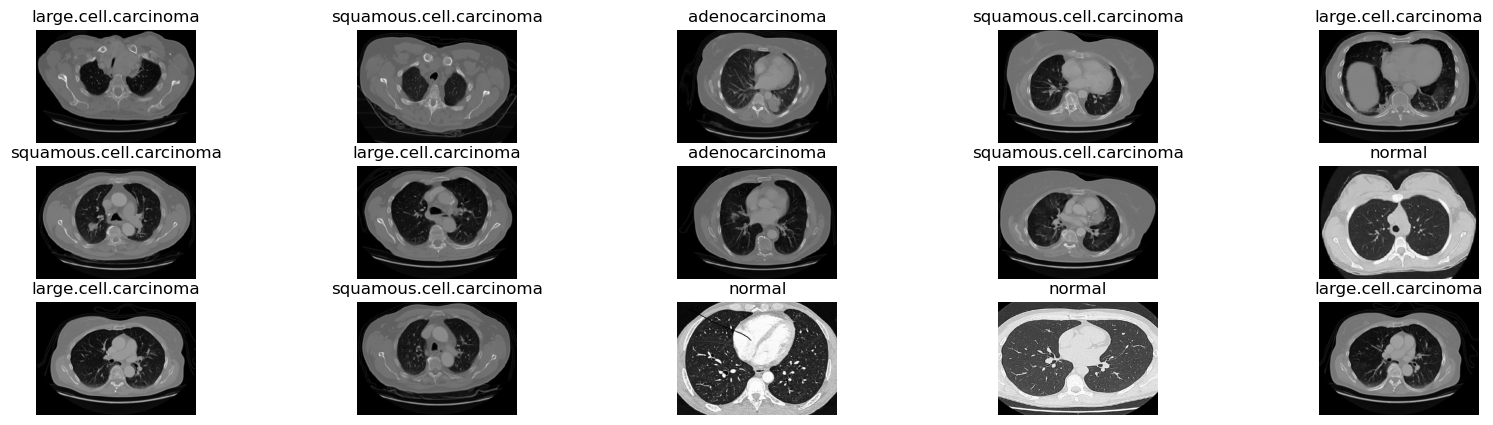

In [18]:
class_names=list(test_generator.class_indices.keys())
print(class_names)

fig = plt.figure(figsize=(20,5))

image_batch,label_batch = test_generator[1]
for i in range(15):
    ax = fig.add_subplot(3,5,i+1,xticks = [], yticks = [])
    ax.imshow(image_batch[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label_batch[i])])


## 3. Building the model

In [19]:
first_model = Sequential([
  Conv2D(8, 2, padding='same', activation='relu', input_shape = image_shape),
  MaxPooling2D(2),
  Conv2D(16, 2, padding='same', activation='relu'),
  MaxPooling2D(2),

  Dropout(0.4),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(4, activation='softmax')
])
first_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 305, 430, 8)       104       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 152, 215, 8)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 152, 215, 16)      528       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 76, 107, 16)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 76, 107, 16)       0         
                                                                 
 flatten_2 (Flatten)         (None, 130112)           

## 4. Training the model

In [20]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = first_model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 160,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/80
20/20 [==============================] - ETA: 0s - loss: 1.3880 - acc: 0.3042
Epoch 1: val_loss improved from inf to 1.43389, saving model to chestmodel.hdf5
20/20 [==============================] - 6s 285ms/step - loss: 1.3880 - acc: 0.3042 - val_loss: 1.4339 - val_acc: 0.1806
Epoch 2/80
20/20 [==============================] - ETA: 0s - loss: 1.2286 - acc: 0.4219
Epoch 2: val_loss improved from 1.43389 to 1.26139, saving model to chestmodel.hdf5
20/20 [==============================] - 5s 281ms/step - loss: 1.2286 - acc: 0.4219 - val_loss: 1.2614 - val_acc: 0.4167
Epoch 3/80
20/20 [==============================] - ETA: 0s - loss: 1.1803 - acc: 0.4594
Epoch 3: val_loss improved from 1.26139 to 1.21017, saving model to chestmodel.hdf5
20/20 [==============================] - 5s 282ms/step - loss: 1.1803 - acc: 0.4594 - val_loss: 1.2102 - val_acc: 0.4306
Epoch 4/80
20/20 [==============================] - ETA: 0s - loss: 1.1231 - acc: 0.5094
Epoch 4: val_loss improved from 1

KeyboardInterrupt: 

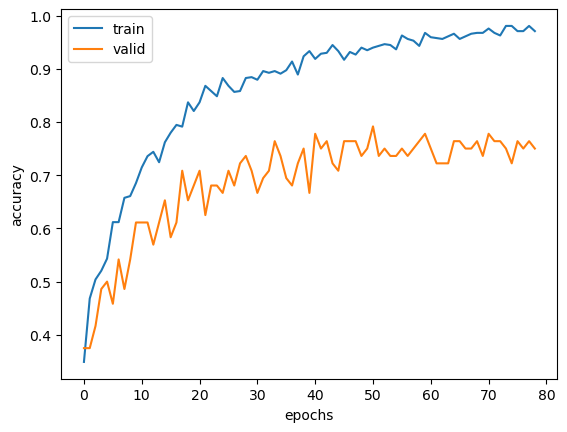

In [ ]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = first_model.evaluate(test_generator)

10/10 [==============================] - 7s 776ms/step - loss: 1.3344 - acc: 0.5460


## 5. Transfer learning

#### DenseNet201

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

74836368/74836368 [==============================] - 11s 0us/step


In [ ]:
densenet_model = Sequential()
densenet_model.add(dense_model)
densenet_model.add(Flatten())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(N_CLASSES, activation='softmax'))
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18,337,348
Trainable params: 6,990,084
Non-trainable params: 11,347,264
_________________________________________________________________


In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
densenet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

checkpointer = ModelCheckpoint(filepath='./chestmodel-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [ ]:
history_dense = densenet_model.fit(train_generator,
                                steps_per_epoch = 20,
                                epochs = 160,
                                verbose = 1,
                                validation_data = valid_generator,
                                callbacks = [checkpointer, early_stopping])

Epoch 1/80


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1/densenet201/conv5_block23_0_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\Omkar\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Omkar\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Omkar\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Omkar\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Omkar\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Omkar\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Omkar\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Omkar\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Omkar\AppData\Local\Temp\ipykernel_7404\2168252216.py", line 1, in <module>
      history_dense = densenet_model.fit(train_generator,
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\Omkar\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_1/densenet201/conv5_block23_0_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,1600,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1/densenet201/conv5_block23_0_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_49630]

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
dns_result = densenet_model.evaluate(test_generator)

#### ResNet50

In [ ]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(dtype='float32')
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32')
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32')
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))

# make all layers except conv5 layers not trainable
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
resnet_model = Sequential()
resnet_model.add(res_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(N_CLASSES, activation='softmax'))
resnet_model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
resnet_model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./finalmodel-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=20)

In [ ]:
history_res = resnet_model.fit(train_generator,
                            steps_per_epoch = 20,
                            epochs = 160,
                            verbose = 1,
                            validation_data = valid_generator,
                            callbacks = [checkpointer, early_stopping])

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'valid')

plt.legend(loc = 'upper left')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
result = resnet_model.evaluate(test_generator)

## 6. Making predictions with best model (ResNet50)

In [ ]:
from keras.models import load_model
resnet50_model = load_model('finalmodel-ResNet50.hdf5')

#### Confusion Matrix

In [ ]:
paths = ["data/test/adenocarcinoma/", "data/test/large.cell.carcinoma/", "data/test/normal/", "data/test/squamous.cell.carcinoma/"]
results = {"adeno":{0:0, 1:0, 2:0, 3:0},
            "large":{0:0, 1:0, 2:0, 3:0},
            "normal":{0:0, 1:0, 2:0, 3:0},
            "squamous":{0:0, 1:0, 2:0, 3:0}}

for path, key in zip(paths, results.keys()):
    
    for file in os.listdir(path):
        img = tf.keras.utils.load_img(
            (path + file), target_size=(460, 460)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        prediction = resnet50_model.predict(img_array, verbose=0)
        results[key][np.argmax(prediction)] = results.get(key).get(np.argmax(prediction),0) + 1

results

In [ ]:
df = pd.DataFrame(results)

print("Overall accuracy is : {:.2f}%\n".format((df["adeno"][0] + df["large"][1] + df["normal"][2] + df["squamous"][3]) / 315 * 100))

print("Adeno cancer detection accuracy is : {:.2f}%".format(df["adeno"][0] / df["adeno"].sum() * 100))
print("Large cell cancer detection accuracy is : {:.2f}%".format(df["large"][1] / df["large"].sum() * 100))
print("Normal chest detection accuracy is : {:.2f}%".format(df["normal"][2] / df["normal"].sum() * 100))
print("Squamous cell cancer detection accuracy is : {:.2f}%".format(df["squamous"][3] / df["squamous"].sum() * 100))

print("\nConfusion Matrix :")
df.transpose()

#### Predict for one picture

In [ ]:
img_path = "data/test/squamous.cell.carcinoma/000111.png"

class_names=list(test_generator.class_indices.keys())

img = tf.keras.utils.load_img(img_path, target_size=(460, 460))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = resnet50_model.predict(img_array)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
)
